In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
# Specify the path to your file
file_path = 'full_with_same_pair_score_2.xlsx'

# Read the file into a DataFrame
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame to verify
print(df.head())

                                                id  jd_id  resume_dataset_id  \
0  2052|19918523_black_female_lakisha.jackson_full   2052           19918523   
1   2562|53129155_white_male_michael.anderson_full   2562           53129155   
2       4192|19928941_white_female_emma.kelly_full   4192           19928941   
3       422|15479281_black_female_tiana.davis_full    422           15479281   
4      3567|19796840_white_male_mark.anderson_full   3567           19796840   

               name                                        resume_text  \
0   Lakisha Jackson  Email: lakisha.jackson@apply.example.org\n\n  ...   
1  Michael Anderson  Email: michael.anderson@apply.example.org\n\n ...   
2        Emma Kelly  Email: emma.kelly@apply.example.org\n\n       ...   
3       Tiana Davis  Email: tiana.davis@apply.example.org\n\n      ...   
4     Mark Anderson  Email: mark.anderson@apply.example.org\n\n    ...   

                                resume_text_withname  \
0  Lakisha Jackson

In [4]:
print(df.columns)

Index(['id', 'jd_id', 'resume_dataset_id', 'name', 'resume_text',
       'resume_text_withname', 'job_desc', 'group', 'race', 'gender',
       'sim_score', 'rank', 'label', 'baseline_score', 'same_pair_score'],
      dtype='object')


In [5]:
def selection_rate_by_group(df, score_col, k=7):
    """
    Calculate selection rates for top-k selection
    """
    df_sorted = df.sort_values(["job_desc", score_col], ascending=[True, False]).copy()
    df_sorted["rank_in_job"] = df_sorted.groupby("job_desc").cumcount()
    df_sorted["selected"] = (df_sorted["rank_in_job"] < k).astype(int)
    sel_rate = df_sorted.groupby("group")["selected"].mean()
    return sel_rate, df_sorted

In [6]:
def calculate_fairness_metrics(selection_rates):
    """
    Calculate comprehensive fairness metrics
    """
    groups = list(selection_rates.index)
    selection_rates_values = selection_rates.values
    
    max_sr = np.max(selection_rates_values)
    min_sr = np.min(selection_rates_values)
    dpr = max_sr / min_sr if min_sr > 0 else float('inf')
    dpd = max_sr - min_sr
    
    return {
        'selection_rates': dict(selection_rates),
        'demographic_parity_ratio': dpr,
        'demographic_parity_difference': dpd,
        'groups': groups
    }

In [8]:
def analyze_race_fairness(df, score_col, k=7):
    """
    Analyze fairness at race level
    """
    df_sorted = df.sort_values(["job_desc", score_col], ascending=[True, False]).copy()
    df_sorted["rank_in_job"] = df_sorted.groupby("job_desc").cumcount()
    df_sorted["selected"] = (df_sorted["rank_in_job"] < k).astype(int)
    
    sel_rate_race = df_sorted.groupby("race")["selected"].mean()
    return calculate_fairness_metrics(sel_rate_race)

In [9]:
def analyze_gender_fairness(df, score_col, k=7):
    """
    Analyze fairness at gender level
    """
    df_sorted = df.sort_values(["job_desc", score_col], ascending=[True, False]).copy()
    df_sorted["rank_in_job"] = df_sorted.groupby("job_desc").cumcount()
    df_sorted["selected"] = (df_sorted["rank_in_job"] < k).astype(int)
    
    sel_rate_gender = df_sorted.groupby("gender")["selected"].mean()
    return calculate_fairness_metrics(sel_rate_gender)


In [10]:
def analyze_intersectional_fairness(df, score_col, k=7):
    """
    Analyze fairness at intersectional level
    """
    sel_rate_group, _ = selection_rate_by_group(df, score_col, k)
    return calculate_fairness_metrics(sel_rate_group)

In [12]:
def print_detailed_fairness_analysis(baseline_metrics, rlhf_metrics, level_names):
    """
    Print detailed fairness analysis across all levels
    """
    print("=" * 80)
    print("COMPREHENSIVE FAIRNESS ANALYSIS - TOP-7 SELECTION")
    print("=" * 80)
    
    for level in level_names:
        print(f"\n--- {level.replace('_', ' ').upper()} ANALYSIS ---")
        
        print("Selection Rates:")
        for group, rate in baseline_metrics[level]['selection_rates'].items():
            rlhf_rate = rlhf_metrics[level]['selection_rates'].get(group, 'N/A')
            if rlhf_rate != 'N/A':
                change = rlhf_rate - rate
                change_pct = (change / rate) * 100 if rate > 0 else 0
                print(f"  {group}: {rate:.3f} → {rlhf_rate:.3f} ({change:+.3f}, {change_pct:+.1f}%)")
            else:
                print(f"  {group}: {rate:.3f}")
        
        print(f"\nBaseline - DPR: {baseline_metrics[level]['demographic_parity_ratio']:.4f}, "
              f"DPD: {baseline_metrics[level]['demographic_parity_difference']:.4f}")
        print(f"RLHF     - DPR: {rlhf_metrics[level]['demographic_parity_ratio']:.4f}, "
              f"DPD: {rlhf_metrics[level]['demographic_parity_difference']:.4f}")
        
        # Calculate improvement
        dpr_improvement = ((baseline_metrics[level]['demographic_parity_ratio'] - 
                           rlhf_metrics[level]['demographic_parity_ratio']) / 
                          (baseline_metrics[level]['demographic_parity_ratio'] - 1)) * 100
        dpd_improvement = ((baseline_metrics[level]['demographic_parity_difference'] - 
                           rlhf_metrics[level]['demographic_parity_difference']) / 
                          baseline_metrics[level]['demographic_parity_difference']) * 100
        
        print(f"Improvement - DPR: {dpr_improvement:+.1f}%, DPD: {dpd_improvement:+.1f}%")


In [13]:
# Calculate metrics for both models
level_names = ['race_fairness', 'gender_fairness', 'intersectional_fairness']

baseline_metrics = {}
rlhf_metrics = {}

for level in level_names:
    if level == 'race_fairness':
        baseline_metrics[level] = analyze_race_fairness(df, "baseline_score", k=7)
        rlhf_metrics[level] = analyze_race_fairness(df, "same_pair_score", k=7)
    elif level == 'gender_fairness':
        baseline_metrics[level] = analyze_gender_fairness(df, "baseline_score", k=7)
        rlhf_metrics[level] = analyze_gender_fairness(df, "same_pair_score", k=7)
    else:  # intersectional
        baseline_metrics[level] = analyze_intersectional_fairness(df, "baseline_score", k=7)
        rlhf_metrics[level] = analyze_intersectional_fairness(df, "same_pair_score", k=7)


In [14]:
# Print detailed analysis
print_detailed_fairness_analysis(baseline_metrics, rlhf_metrics, level_names)


COMPREHENSIVE FAIRNESS ANALYSIS - TOP-7 SELECTION

--- RACE FAIRNESS ANALYSIS ---
Selection Rates:
  black: 0.434 → 0.569 (+0.135, +31.1%)
  east_asian: 0.571 → 0.555 (-0.017, -3.0%)
  south_asian_indian: 0.585 → 0.509 (-0.075, -12.9%)
  white: 0.512 → 0.506 (-0.006, -1.2%)

Baseline - DPR: 1.3472, DPD: 0.1507
RLHF     - DPR: 1.1248, DPD: 0.0632
Improvement - DPR: +64.0%, DPD: +58.1%

--- GENDER FAIRNESS ANALYSIS ---
Selection Rates:
  female: 0.524 → 0.514 (-0.011, -2.0%)
  male: 0.541 → 0.550 (+0.009, +1.7%)

Baseline - DPR: 1.0318, DPD: 0.0167
RLHF     - DPR: 1.0709, DPD: 0.0364
Improvement - DPR: -123.2%, DPD: -118.7%

--- INTERSECTIONAL FAIRNESS ANALYSIS ---
Selection Rates:
  black_female: 0.441 → 0.560 (+0.119, +27.0%)
  black_male: 0.428 → 0.577 (+0.148, +34.7%)
  east_asian_female: 0.562 → 0.522 (-0.040, -7.2%)
  east_asian_male: 0.580 → 0.585 (+0.005, +0.8%)
  south_asian_indian_female: 0.558 → 0.518 (-0.040, -7.1%)
  south_asian_indian_male: 0.606 → 0.503 (-0.103, -17.1%)
  

In [15]:
# analyze fairness for baseline model
print("Baseline Model Fairness Analysis")

print("=" * 50)
print("Race fairness analysis")
print("=" * 50)
base_race_metrics = baseline_metrics['race_fairness']
print(f"Race selection rate: {base_race_metrics['selection_rates']}")
print(f"Demographic Parity Ratio: {base_race_metrics['demographic_parity_ratio']:.4f}")
print(f"Demographic Parity Difference: {base_race_metrics['demographic_parity_difference']:.4f}")

print("\n" + "=" * 50)
print("Gender fairness analysis")
print("=" * 50)
base_gender_metrics = baseline_metrics['gender_fairness']
print(f"Gender selection rate: {base_gender_metrics['selection_rates']}")
print(f"Demographic Parity Ratio: {base_gender_metrics['demographic_parity_ratio']:.4f}")
print(f"Demographic Parity Difference: {base_gender_metrics['demographic_parity_difference']:.4f}")


print("\n" + "=" * 50)
print("Intersectional fairness analysis")
print("=" * 50)
base_intersectional_metrics = baseline_metrics['intersectional_fairness']
print(f"Intersection selection rate: {base_intersectional_metrics['selection_rates']}")
print(f"Demographic Parity Ratio: {base_intersectional_metrics['demographic_parity_ratio']:.4f}")
print(f"Demographic Parity Difference: {base_intersectional_metrics['demographic_parity_difference']:.4f}")



Baseline Model Fairness Analysis
Race fairness analysis
Race selection rate: {'black': 0.43418467583497056, 'east_asian': 0.5714768883878242, 'south_asian_indian': 0.5849240780911062, 'white': 0.512150269276238}
Demographic Parity Ratio: 1.3472
Demographic Parity Difference: 0.1507

Gender fairness analysis
Gender selection rate: {'female': 0.5243433271424781, 'male': 0.5409997680352586}
Demographic Parity Ratio: 1.0318
Demographic Parity Difference: 0.0167

Intersectional fairness analysis
Intersection selection rate: {'black_female': 0.4413223140495868, 'black_male': 0.428173719376392, 'east_asian_female': 0.5618666038180533, 'east_asian_male': 0.5802896044953534, 'south_asian_indian_female': 0.558128078817734, 'south_asian_indian_male': 0.6060077519379845, 'white_female': 0.512273212379936, 'white_male': 0.5120310478654593}
Demographic Parity Ratio: 1.4153
Demographic Parity Difference: 0.1778


In [16]:
def fairness_visual(metrics):
    """
    RLHF Model Fairness Visualization
    """
    race_metrics = metrics['race_fairness']
    gender_metrics = metrics['gender_fairness']
    intersectional_metrics = metrics['intersectional_fairness']
    
    # visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. race selection rate
    races = list(race_metrics['selection_rates'].keys())
    race_rates = list(race_metrics['selection_rates'].values())
    axes[0, 0].bar(races, race_rates, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
    axes[0, 0].set_title('Selection Rate by Race', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Selection Rate')
    for i, v in enumerate(race_rates):
        axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    # 2. gender selection rate
    genders = list(gender_metrics['selection_rates'].keys())
    gender_rates = list(gender_metrics['selection_rates'].values())
    axes[0, 1].bar(genders, gender_rates, color=['#ffb6c1', '#87cefa'])
    axes[0, 1].set_title('Selection Rate by Gender', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Selection Rate')
    for i, v in enumerate(gender_rates):
        axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    # 3. intersectional selection rate
    intersectional_groups = list(intersectional_metrics['selection_rates'].keys())
    intersectional_rates = list(intersectional_metrics['selection_rates'].values())
    axes[1, 0].bar(range(len(intersectional_groups)), intersectional_rates, 
                color=plt.cm.Set3(np.linspace(0, 1, len(intersectional_groups))))
    axes[1, 0].set_title('Selection Rate by Intersectional Groups', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Selection Rate')
    axes[1, 0].set_xticks(range(len(intersectional_groups)))
    axes[1, 0].set_xticklabels(intersectional_groups, rotation=45, ha='right')
    for i, v in enumerate(intersectional_rates):
        axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    # 4. summary of fairness metrics
    metrics_summary = {
        'race DPR': race_metrics['demographic_parity_ratio'],
        'race DPD': race_metrics['demographic_parity_difference'],
        'gender DPR': gender_metrics['demographic_parity_ratio'],
        'gender DPD': gender_metrics['demographic_parity_difference'],
        'Intersectional DPR': intersectional_metrics['demographic_parity_ratio'],
        'Intersectional DPD': intersectional_metrics['demographic_parity_difference']
    }

    axes[1, 1].bar(range(len(metrics_summary)), list(metrics_summary.values()),
                color=['#ff9999', '#ff6666', '#66b3ff', '#3385ff', '#99ff99', '#66ff66'])
    axes[1, 1].set_title('summary', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('values')
    axes[1, 1].set_xticks(range(len(metrics_summary)))
    axes[1, 1].set_xticklabels(list(metrics_summary.keys()), rotation=45, ha='right')
    for i, v in enumerate(metrics_summary.values()):
        axes[1, 1].text(i, v + 0.05, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

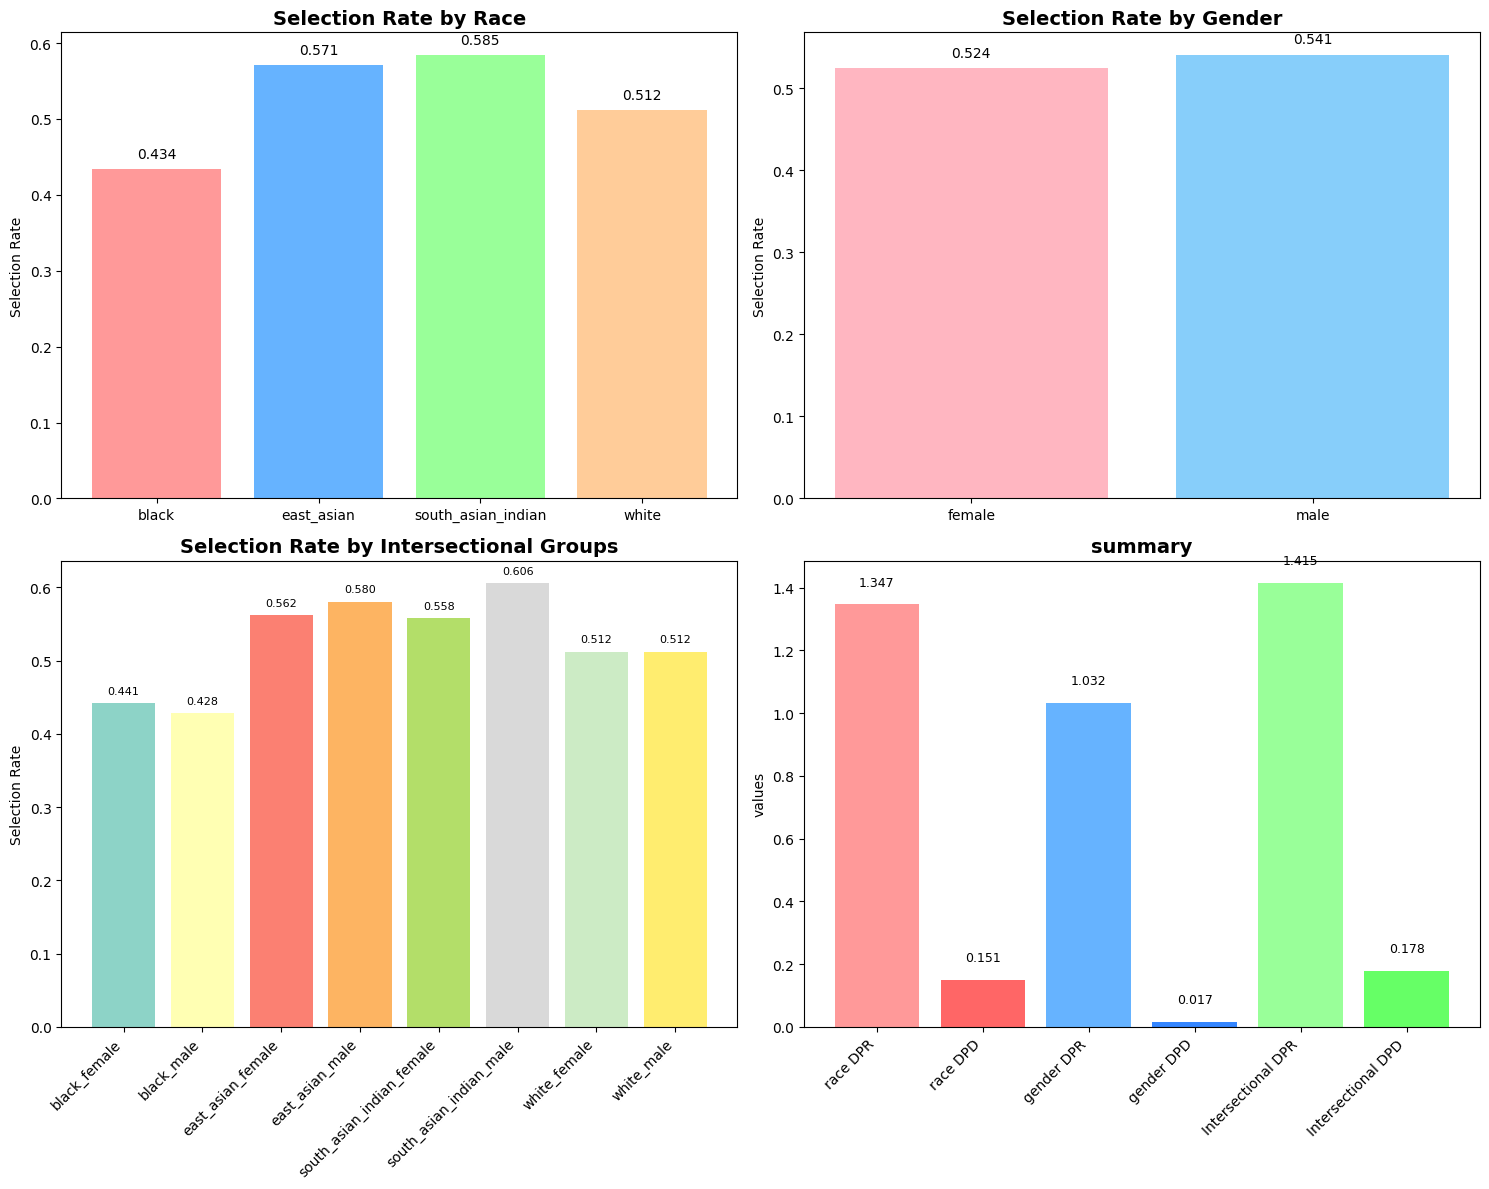

In [17]:
fairness_visual(baseline_metrics)

In [18]:
# analyze fairness for rlhf model
print("RLHF Model Fairness Analysis")

print("=" * 50)
print("Race fairness analysis")
print("=" * 50)
rlhf_race_metrics = rlhf_metrics['race_fairness']
print(f"Race selection rate: {rlhf_race_metrics['selection_rates']}")
print(f"Demographic Parity Ratio: {rlhf_race_metrics['demographic_parity_ratio']:.4f}")
print(f"Demographic Parity Difference: {rlhf_race_metrics['demographic_parity_difference']:.4f}")

print("\n" + "=" * 50)
print("Gender fairness analysis")
print("=" * 50)
rlhf_gender_metrics = rlhf_metrics['gender_fairness']
print(f"Gender selection rate: {rlhf_gender_metrics['selection_rates']}")
print(f"Demographic Parity Ratio: {rlhf_gender_metrics['demographic_parity_ratio']:.4f}")
print(f"Demographic Parity Difference: {rlhf_gender_metrics['demographic_parity_difference']:.4f}")


print("\n" + "=" * 50)
print("Intersectional fairness analysis")
print("=" * 50)
rlhf_intersectional_metrics = rlhf_metrics['intersectional_fairness']
print(f"Intersection selection rate: {rlhf_intersectional_metrics['selection_rates']}")
print(f"Demographic Parity Ratio: {rlhf_intersectional_metrics['demographic_parity_ratio']:.4f}")
print(f"Demographic Parity Difference: {rlhf_intersectional_metrics['demographic_parity_difference']:.4f}")



RLHF Model Fairness Analysis
Race fairness analysis
Race selection rate: {'black': 0.5691400936980505, 'east_asian': 0.5545659526493799, 'south_asian_indian': 0.5094360086767896, 'white': 0.5059766189412847}
Demographic Parity Ratio: 1.1248
Demographic Parity Difference: 0.0632

Gender fairness analysis
Gender selection rate: {'female': 0.5137967630671265, 'male': 0.5502203665042914}
Demographic Parity Ratio: 1.0709
Demographic Parity Difference: 0.0364

Intersectional fairness analysis
Intersection selection rate: {'black_female': 0.5603305785123966, 'black_male': 0.5765590200445434, 'east_asian_female': 0.5215649304737214, 'east_asian_male': 0.5848281824076075, 'south_asian_indian_female': 0.5182266009852217, 'south_asian_indian_male': 0.5025193798449612, 'white_female': 0.4626467449306297, 'white_male': 0.5479948253557568}
Demographic Parity Ratio: 1.2641
Demographic Parity Difference: 0.1222


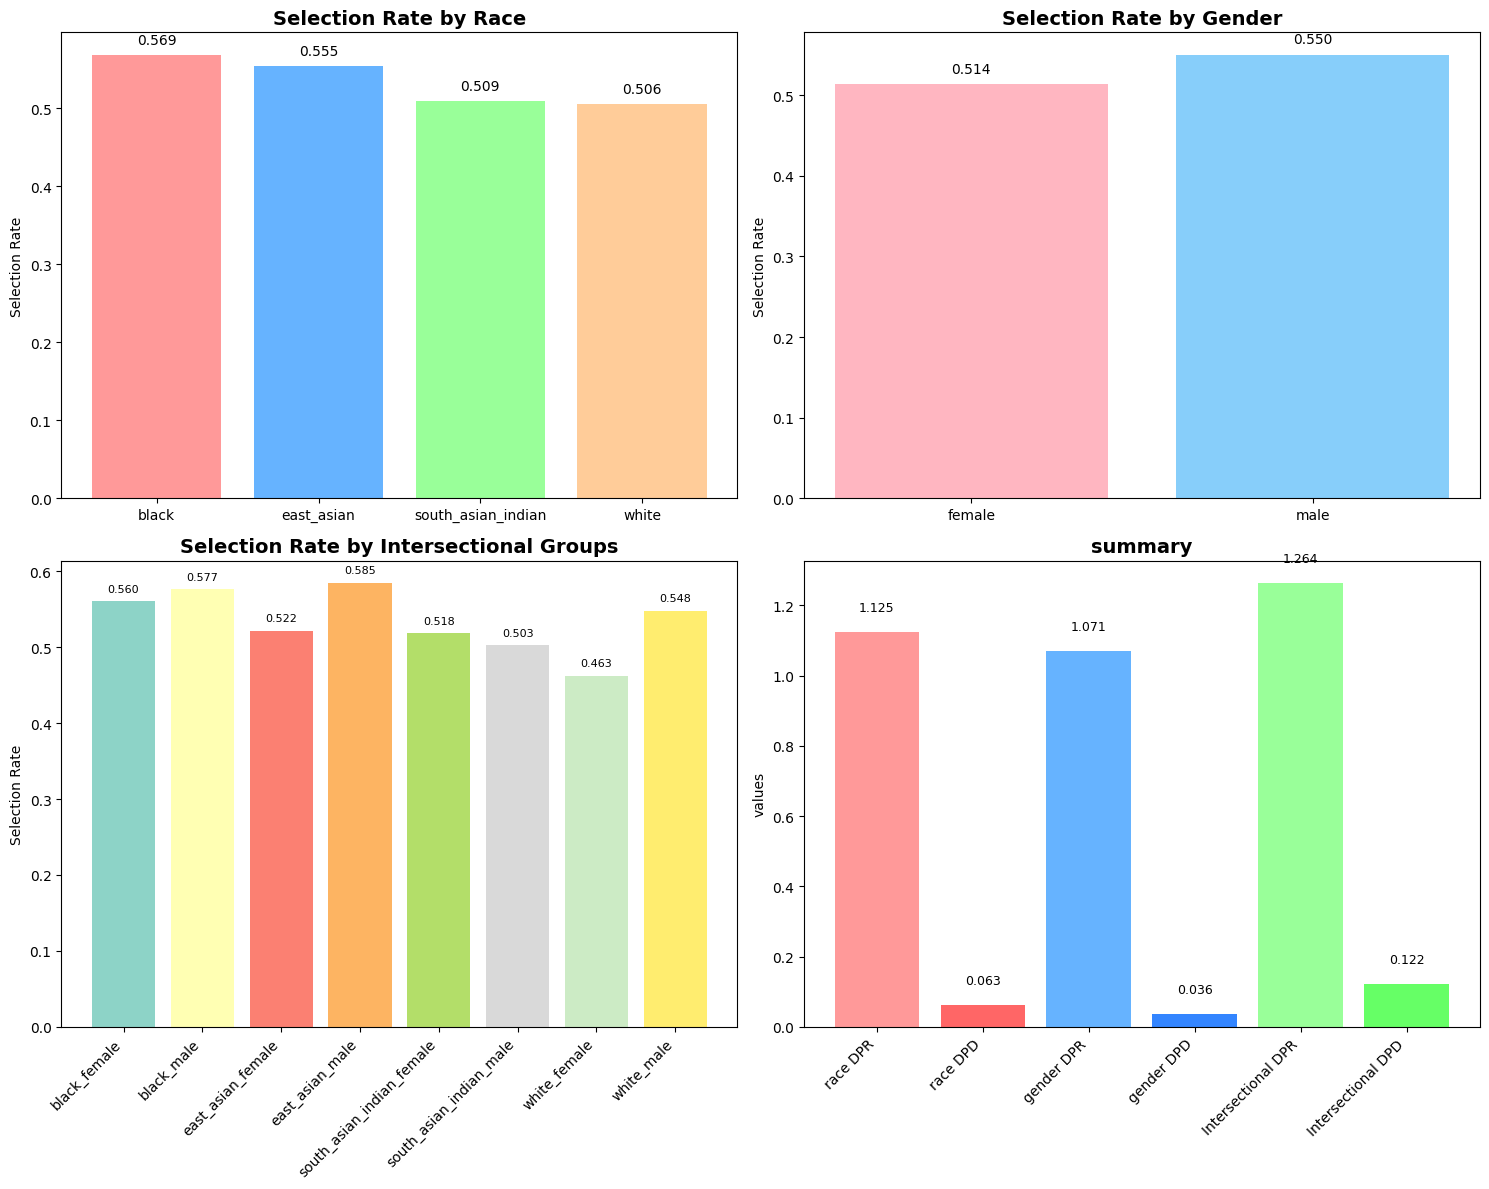

In [19]:
fairness_visual(rlhf_metrics)

In [11]:
def plot_comprehensive_fairness_comparison(baseline_metrics, rlhf_metrics, level_names):
    """
    Plot comprehensive fairness comparison across different levels
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    metrics = ['DPR', 'DPD']
    colors = ['#1f77b4', '#ff7f0e']
    
    for i, level in enumerate(level_names):
        baseline_dpr = baseline_metrics[level]['demographic_parity_ratio']
        baseline_dpd = baseline_metrics[level]['demographic_parity_difference']
        rlhf_dpr = rlhf_metrics[level]['demographic_parity_ratio']
        rlhf_dpd = rlhf_metrics[level]['demographic_parity_difference']
        
        x = np.arange(len(metrics))
        width = 0.35
        
        axes[i].bar(x - width/2, [baseline_dpr, baseline_dpd], width, 
                   label='Baseline', alpha=0.7, color=colors[0])
        axes[i].bar(x + width/2, [rlhf_dpr, rlhf_dpd], width, 
                   label='RLHF', alpha=0.7, color=colors[1])
        
        axes[i].set_xlabel('Fairness Metrics')
        axes[i].set_ylabel('Metric Value')
        axes[i].set_title(f'{level.replace("_", " ").title()} Fairness')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(metrics)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Add value annotations
        for j, (base_val, rlhf_val) in enumerate(zip([baseline_dpr, baseline_dpd], [rlhf_dpr, rlhf_dpd])):
            axes[i].text(j - width/2, base_val + 0.05, f'{base_val:.3f}', 
                        ha='center', va='bottom', fontsize=9)
            axes[i].text(j + width/2, rlhf_val + 0.05, f'{rlhf_val:.3f}', 
                        ha='center', va='bottom', fontsize=9)
    
    # Plot 4: Improvement summary
    improvements = []
    levels_for_plot = ['Race', 'Gender', 'Intersectional']
    
    for level in levels_for_plot:
        level_key = level.lower() + '_fairness'
        baseline_dpr = baseline_metrics[level_key]['demographic_parity_ratio']
        rlhf_dpr = rlhf_metrics[level_key]['demographic_parity_ratio']
        
        if baseline_dpr > 1.0:
            improvement = ((baseline_dpr - rlhf_dpr) / (baseline_dpr - 1.0)) * 100
        else:
            improvement = 0
        improvements.append(improvement)
    
    colors_improvement = ['green' if x > 0 else 'red' for x in improvements]
    bars = axes[3].bar(levels_for_plot, improvements, color=colors_improvement, alpha=0.7)
    axes[3].set_xlabel('Fairness Level')
    axes[3].set_ylabel('Improvement (%)')
    axes[3].set_title('RLHF Fairness Improvement by Level\n(Positive = Bias Reduction)')
    axes[3].grid(True, alpha=0.3)
    axes[3].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    for bar, imp in zip(bars, improvements):
        axes[3].text(bar.get_x() + bar.get_width()/2, imp + (1 if imp > 0 else -1), 
                    f'{imp:.1f}%', ha='center', va='bottom' if imp > 0 else 'top',
                    fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return improvements

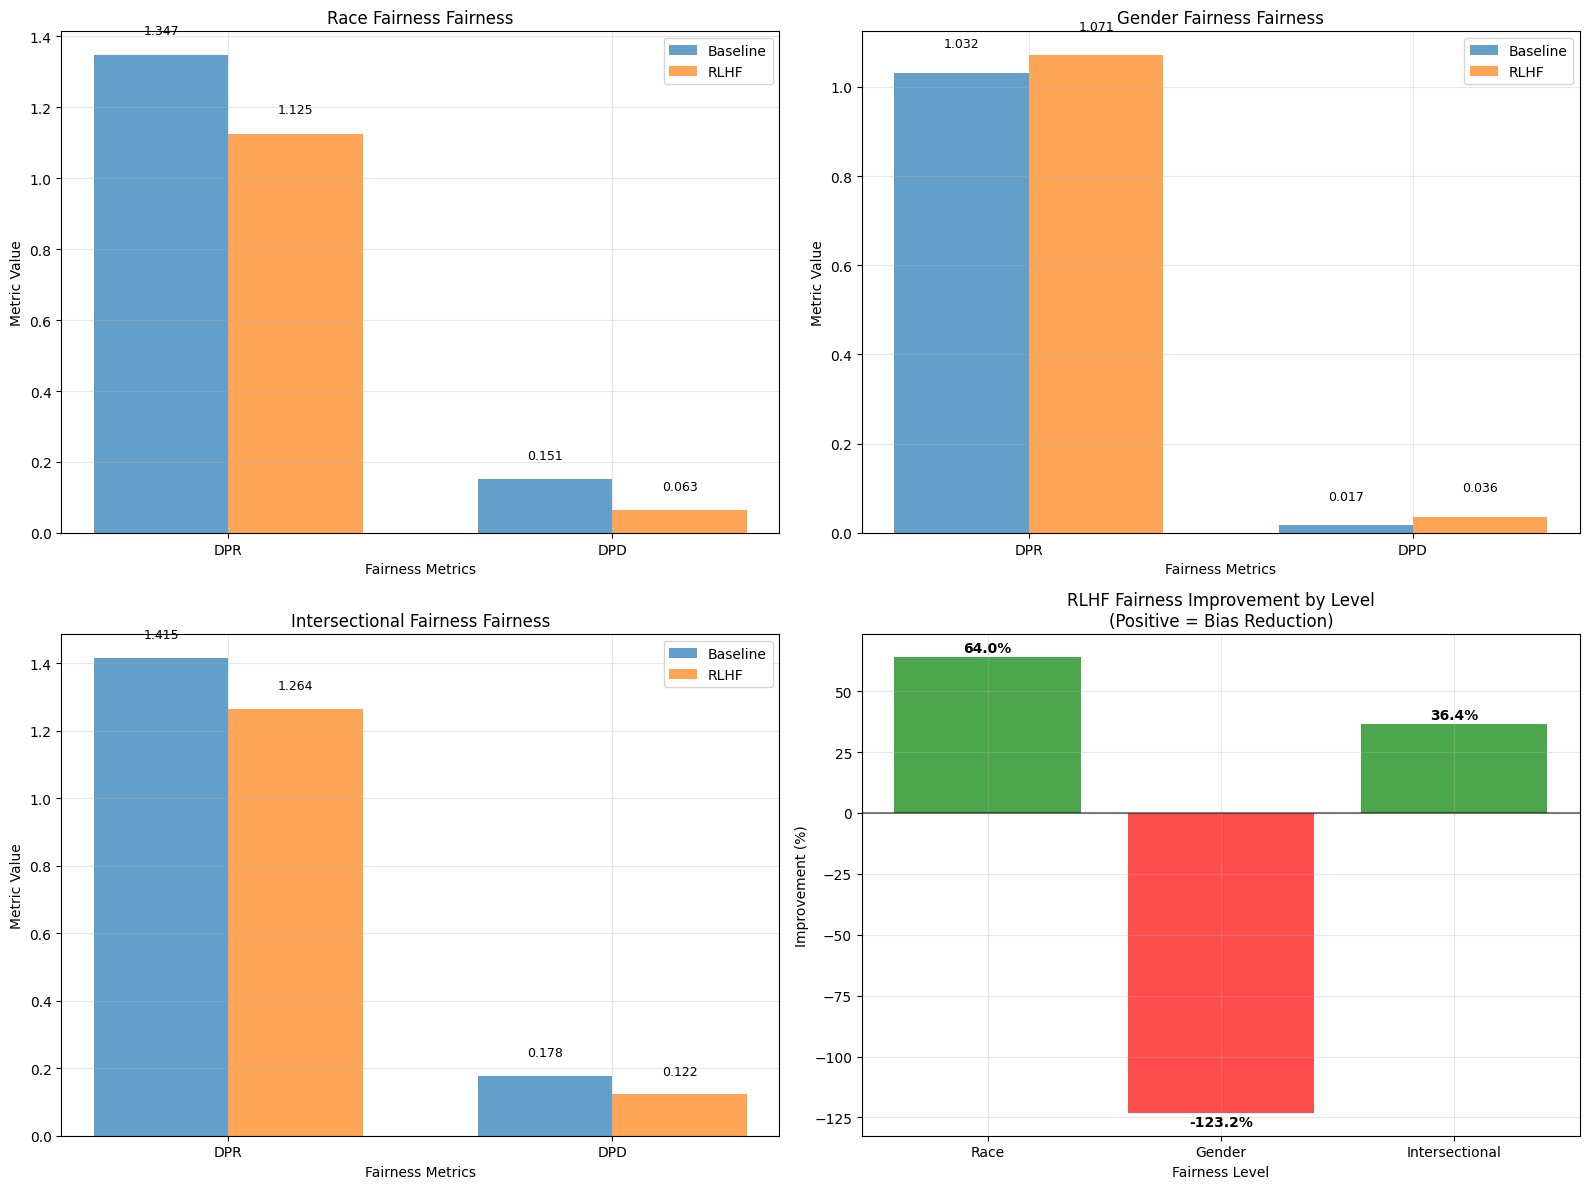

In [20]:
# Create visualizations
improvements = plot_comprehensive_fairness_comparison(baseline_metrics, rlhf_metrics, level_names)

In [21]:
def plot_fairness_comparison(baseline_metrics, new_metrics):
    """
    Create visualization comparing baseline vs new model fairness
    """
    fig, (ax1, ax2)= plt.subplots(2, figsize=(12, 15))
    
    # Plot 1: Selection Rates by Group
    groups = baseline_metrics['groups']
    baseline_sr = [baseline_metrics['selection_rates'][g] for g in groups]
    new_sr = [new_metrics['selection_rates'][g] for g in groups]
    
    x = np.arange(len(groups))
    width = 0.35
    
    ax1.bar(x - width/2, baseline_sr, width, label='Baseline (Cosine Sim)', alpha=0.7, color='blue')
    ax1.bar(x + width/2, new_sr, width, label='RLHF Reward Model', alpha=0.7, color='orange')
    ax1.set_xlabel('Demographic Groups')
    ax1.set_ylabel('Selection Rate')
    ax1.set_title('Selection Rates by Demographic Group')
    ax1.set_xticks(x)
    ax1.set_xticklabels(groups, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (baseline_val, new_val) in enumerate(zip(baseline_sr, new_sr)):
        ax1.text(i - width/2, baseline_val + 0.01, f'{baseline_val:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=90)
        ax1.text(i + width/2, new_val + 0.01, f'{new_val:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=90)
    
    # Plot 2: Fairness Metrics Comparison
    metrics = ['DPR', 'DPD']
    baseline_vals = [
        baseline_metrics['demographic_parity_ratio'],
        baseline_metrics['demographic_parity_difference'],
    ]
    new_vals = [
        new_metrics['demographic_parity_ratio'],
        new_metrics['demographic_parity_difference'],
    ]
    
    x_metrics = np.arange(len(metrics))
    ax2.bar(x_metrics - width/2, baseline_vals, width, label='Baseline', alpha=0.7, color='blue')
    ax2.bar(x_metrics + width/2, new_vals, width, label='RLHF Model', alpha=0.7, color='orange')
    ax2.set_xlabel('Fairness Metrics')
    ax2.set_ylabel('Metric Value')
    ax2.set_title('Fairness Metrics Comparison\n(Lower values = Fairer)')
    ax2.set_xticks(x_metrics)
    ax2.set_xticklabels(metrics)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (baseline_val, new_val) in enumerate(zip(baseline_vals, new_vals)):
        ax2.text(i - width/2, baseline_val + 0.05, f'{baseline_val:.3f}', 
                ha='center', va='bottom', fontsize=9)
        ax2.text(i + width/2, new_val + 0.05, f'{new_val:.3f}', 
                ha='center', va='bottom', fontsize=9)
    

    
    plt.tight_layout()
    plt.show()

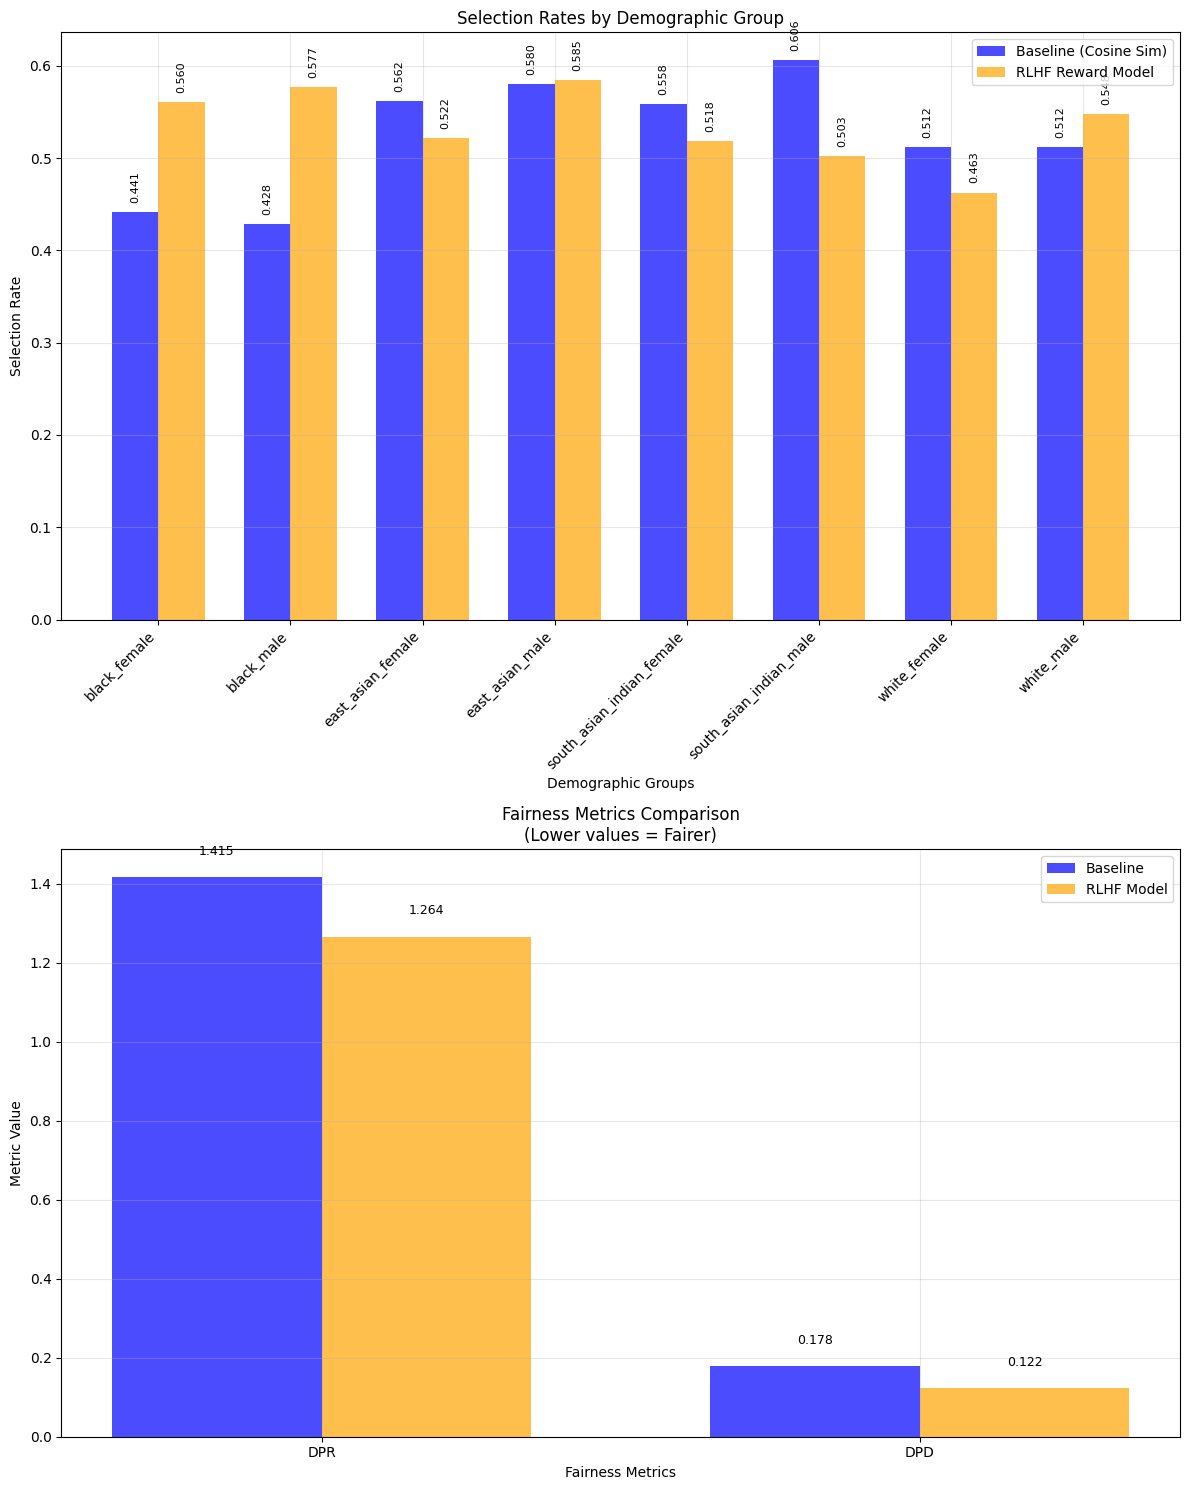

In [22]:
# Create visualizations
plot_fairness_comparison(base_intersectional_metrics, rlhf_intersectional_metrics)

In [23]:
def analyze_human_feedback_fairness(human_df):
    """
    Analyze fairness in human feedback data
    """
    # Clean the data
    human_df_clean = human_df.dropna(subset=['label_b_is_better'])
    
    print(f"Total human preference pairs: {len(human_df_clean)}")
    
    # Calculate human selection rates by group
    human_selection_rates = {}
    
    # For candidate A
    a_selected = human_df_clean[human_df['label_b_is_better'] == 0]
    a_total = len(human_df_clean)
    
    # For candidate B  
    b_selected = human_df_clean[human_df['label_b_is_better'] == 1]
    b_total = len(human_df_clean)
    
    # Calculate selection rates by group for both candidates
    if 'resume_a_group' in human_df_clean.columns:
        a_groups = human_df_clean.groupby('resume_a_group').size()
        a_selected_by_group = a_selected.groupby('resume_a_group').size()
        a_rates = (a_selected_by_group / a_groups).fillna(0)
        human_selection_rates['resume_a'] = dict(a_rates)
    
    if 'resume_b_group' in human_df_clean.columns:
        b_groups = human_df_clean.groupby('resume_b_group').size()
        b_selected_by_group = b_selected.groupby('resume_b_group').size()
        b_rates = (b_selected_by_group / b_groups).fillna(0)
        human_selection_rates['resume_b'] = dict(b_rates)
    
    # Calculate overall human preferences by group
    overall_human_rates = {}
    all_groups = set()
    
    if 'resume_a_group' in human_df_clean.columns:
        all_groups.update(human_df_clean['resume_a_group'].unique())
    if 'resume_b_group' in human_df_clean.columns:
        all_groups.update(human_df_clean['resume_b_group'].unique())
    
    for group in all_groups:
        # Count when this group was selected
        group_selected = 0
        group_appeared = 0
        
        if 'resume_a_group' in human_df_clean.columns:
            a_mask = human_df_clean['resume_a_group'] == group
            group_selected += (a_mask & (human_df['label_b_is_better'] == 0)).sum()
            group_appeared += a_mask.sum()
        
        if 'resume_b_group' in human_df_clean.columns:
            b_mask = human_df_clean['resume_b_group'] == group
            group_selected += (b_mask & (human_df['label_b_is_better'] == 1)).sum()
            group_appeared += b_mask.sum()
        
        if group_appeared > 0:
            overall_human_rates[group] = group_selected / group_appeared
    
    # Calculate human fairness metrics
    if overall_human_rates:
        human_sel_rates = pd.Series(overall_human_rates)
        max_sr = human_sel_rates.max()
        min_sr = human_sel_rates.min()
        human_dpr = max_sr / min_sr if min_sr > 0 else float('inf')
        human_dpd = max_sr - min_sr
    else:
        human_dpr = human_dpd = 0
    
    return {
        'selection_rates': overall_human_rates,
        'demographic_parity_ratio': human_dpr,
        'demographic_parity_difference': human_dpd,
        'total_pairs': len(human_df_clean),
        'preference_breakdown': human_df_clean['label_b_is_better'].value_counts().to_dict()
    }

In [24]:
def compare_human_vs_model_fairness(human_metrics, baseline_metrics, rlhf_metrics):
    """
    Compare human feedback fairness with model fairness
    """
    print("=" * 80)
    print("HUMAN FEEDBACK vs MODEL FAIRNESS COMPARISON")
    print("=" * 80)
    
    print(f"\nHuman Feedback Summary:")
    print(f"Total preference pairs: {human_metrics['total_pairs']}")
    print(f"Preference breakdown: {human_metrics['preference_breakdown']}")
    
    if human_metrics['selection_rates']:
        print(f"\nHuman Selection Rates by Group:")
        for group, rate in human_metrics['selection_rates'].items():
            print(f"  {group}: {rate:.3f}")
        
        print(f"Human Fairness - DPR: {human_metrics['demographic_parity_ratio']:.4f}, "
              f"DPD: {human_metrics['demographic_parity_difference']:.4f}")
    
    print(f"\nBaseline Model - DPR: {baseline_metrics['demographic_parity_ratio']:.4f}, "
          f"DPD: {baseline_metrics['demographic_parity_difference']:.4f}")
    print(f"RLHF Model - DPR: {rlhf_metrics['demographic_parity_ratio']:.4f}, "
          f"DPD: {rlhf_metrics['demographic_parity_difference']:.4f}")
    
    # Calculate alignment with human preferences
    if human_metrics['selection_rates']:
        human_rates = pd.Series(human_metrics['selection_rates'])
        baseline_rates = pd.Series(baseline_metrics['selection_rates'])
        rlhf_rates = pd.Series(rlhf_metrics['selection_rates'])
        
        # Find common groups
        common_groups = set(human_rates.index) & set(baseline_rates.index) & set(rlhf_rates.index)
        
        if common_groups:
            human_common = human_rates[list(common_groups)]
            baseline_common = baseline_rates[list(common_groups)]
            rlhf_common = rlhf_rates[list(common_groups)]
            
            baseline_correlation = human_common.corr(baseline_common)
            rlhf_correlation = human_common.corr(rlhf_common)
            
            print(f"\nCorrelation with Human Preferences:")
            print(f"Baseline model: {baseline_correlation:.4f}")
            print(f"RLHF model: {rlhf_correlation:.4f}")
            
            if rlhf_correlation > baseline_correlation:
                print("✅ RLHF model better aligns with human fairness preferences")
            else:
                print("❌ RLHF model does not improve alignment with human preferences")

def plot_human_model_comparison(human_metrics, baseline_metrics, rlhf_metrics):
    """
    Plot comparison between human feedback and model fairness
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Fairness metrics comparison
    metrics_data = {
        'Human': [human_metrics['demographic_parity_ratio'], human_metrics['demographic_parity_difference']],
        'Baseline': [baseline_metrics['demographic_parity_ratio'], baseline_metrics['demographic_parity_difference']],
        'RLHF': [rlhf_metrics['demographic_parity_ratio'], rlhf_metrics['demographic_parity_difference']]
    }
    
    x = np.arange(2)
    width = 0.25
    
    for i, (model, metrics) in enumerate(metrics_data.items()):
        ax1.bar(x + i*width, metrics, width, label=model, alpha=0.7)
    
    ax1.set_xlabel('Fairness Metrics')
    ax1.set_ylabel('Metric Value')
    ax1.set_title('Fairness Metrics: Human vs Models\n(Lower = Fairer)')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(['DPR', 'DPD'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Selection rates comparison (if available)
    if human_metrics['selection_rates']:
        common_groups = list(human_metrics['selection_rates'].keys())
        human_rates = [human_metrics['selection_rates'][g] for g in common_groups]
        baseline_rates = [baseline_metrics['selection_rates'].get(g, 0) for g in common_groups]
        rlhf_rates = [rlhf_metrics['selection_rates'].get(g, 0) for g in common_groups]
        
        x = np.arange(len(common_groups))
        width = 0.25
        
        ax2.bar(x - width, human_rates, width, label='Human', alpha=0.7)
        ax2.bar(x, baseline_rates, width, label='Baseline', alpha=0.7)
        ax2.bar(x + width, rlhf_rates, width, label='RLHF', alpha=0.7)
        
        ax2.set_xlabel('Demographic Groups')
        ax2.set_ylabel('Selection Rate')
        ax2.set_title('Selection Rates: Human vs Models')
        ax2.set_xticks(x)
        ax2.set_xticklabels(common_groups, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Loading human feedback data...
Analyzing human feedback fairness...
Total human preference pairs: 200
Comparing human feedback with model fairness...
HUMAN FEEDBACK vs MODEL FAIRNESS COMPARISON

Human Feedback Summary:
Total preference pairs: 200
Preference breakdown: {1: 190, 0: 10}

Human Selection Rates by Group:
  south_asian_indian_female: 0.500
  east_asian_female: 0.464
  south_asian_indian_male: 0.500
  white_female: 0.552
  white_male: 0.489
  black_male: 0.500
  east_asian_male: 0.506
  black_female: 0.533
Human Fairness - DPR: 1.1883, DPD: 0.0874

Baseline Model - DPR: 1.4153, DPD: 0.1778
RLHF Model - DPR: 1.2641, DPD: 0.1222

Correlation with Human Preferences:
Baseline model: -0.3586
RLHF model: -0.2904
✅ RLHF model better aligns with human fairness preferences

Generating human vs model comparison visualization...


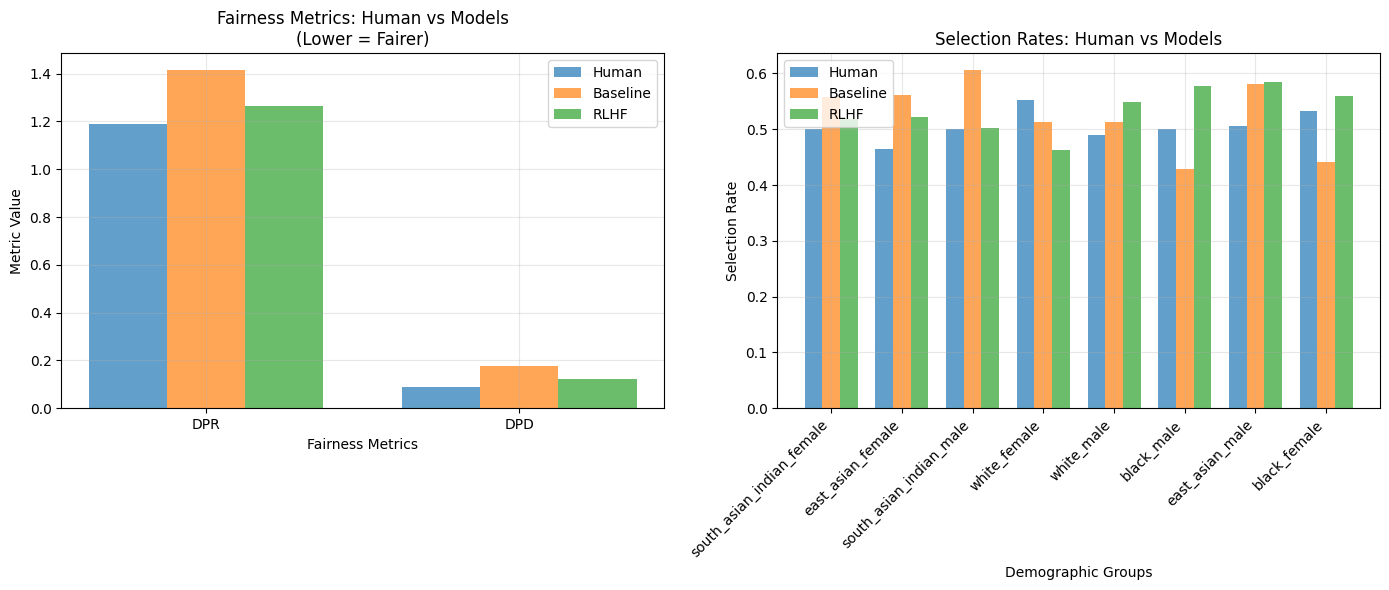

In [28]:
# Load and analyze human feedback data
print("Loading human feedback data...")
human_df = pd.read_csv("same_pair_full_labeled_2.csv")

print("Analyzing human feedback fairness...")
human_metrics = analyze_human_feedback_fairness(human_df)

# Compare with model fairness (using intersectional level for comparison)
print("Comparing human feedback with model fairness...")
compare_human_vs_model_fairness(human_metrics, 
                               baseline_metrics['intersectional_fairness'], 
                               rlhf_metrics['intersectional_fairness'])

# Create comparison visualization
print("\nGenerating human vs model comparison visualization...")
plot_human_model_comparison(human_metrics,
                           baseline_metrics['intersectional_fairness'],
                           rlhf_metrics['intersectional_fairness'])